# Flow direction calculation

This script demonstrates how to calculate the flow direction and rates for the diffusers of the Dronninglund PTES.

The reason this is necessary is that the flow rate is only measured in two of the three diffuser pipes and that the flow directions (either to or from the storage) are believed to be inaccurate.

Import necesarry packages:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<br> Define functions for density and specific heat of water as a function of temperature:

In [5]:
def density_water(T):
    '''Density (rho) of water in kg/m^3 based on fluid temperature (T) nearest the flow meter in degrees Celsius'''
    rho = (999.85+5.332*(10**-2)*T-7.564*(10**-3)*(T**2)+4.323*(10**-5)*(T**3)-1.673*(10**-7)*(T**4)+2.447*(10**-10)*(T**5))
    return(rho)

def specific_heat_water(T):
    '''Specific heat (cp) of water in J/(kg K) based on mean fluid temperature (T) in degrees Celsius'''
    cp = (4.2184-2.8218*(10**-3)*T+7.3478*(10**-5)*(T**2)-9.4712*(10**-7)*(T**3)+7.2869*(10**-9)*(T**4)-2.8098*(10**-11)*(T**5)
          +4.4008*(10**-14)*(T**6))*1000
    return(cp)

<br> Read the quality controlled measurement data into a dataframe:

In [6]:
df = pd.read_csv('../data/processed/Dronninglund_treated_data.csv', index_col=[0], parse_dates=True)
df

,SO.DA.ET.422.5,SO.DA.HT.422.1.F,SO.DA.HT.422.1.T,SO.DA.HT.422.2.F,SO.DA.HT.422.2.T,SO.DA.LT.421,T_00.5,T_01.5,T_02.5,T_03.5,...,SO.TR.PT.443,SO.TR.PT.444,SO.TR.TT.419,SO.TR.TT.420,SO.TR.TT.421,SO.TR.TT.430,SO.VP.TT.454,temp_dry,radia_glob,temp_dry.1
2014-01-01 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,0.0,4.2
2014-01-01 01:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,0.0,4.2
2014-01-01 01:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,0.0,4.1
2014-01-01 01:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,0.0,4.1
2014-01-01 01:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01 00:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,0.0,NaN
2021-01-01 00:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,0.0,NaN
2021-01-01 00:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,0.0,NaN
2021-01-01 00:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,0.0,NaN


<br> In order to find the energy stored in the PTES, the first step is to determine the energy produced by the two solar collector fields. As the energy production rates are logged as cummulative values, the production during each timestep can be calculated using the *.diff()* function. The relevant parameters are:
* 'SO.F1.PRO.ENERGI.T'   : Produced solar energy from field 1
* 'SO.F2.PRO.ENERGI.T'   : Produced solar energy from field 2
* 'SO.F1.AFBL.ENERGI.T'  : Energy used for storage night cooling field 1
* 'SO.F2.AFBL.ENERGI.T'  : Energy used for storage night cooling field 2
* 'SO.F1.FROST.ENERGI.T' : Energy used for defrosting field 1 in the winter
* 'SO.F2.FROST.ENERGI.T' : Energy used for defrosting field 2 in the winter

In [7]:
df['Q_solar_1'] = df['SO.F1.PRO.ENERGI.T'].diff() - df['SO.F1.AFBL.ENERGI.T'].diff() - df['SO.F1.FROST.ENERGI.T'].diff()
df['Q_solar_2'] = df['SO.F2.PRO.ENERGI.T'].diff() - df['SO.F2.AFBL.ENERGI.T'].diff() - df['SO.F2.FROST.ENERGI.T'].diff()

<br> The second step is to calculate the energy supplied to town (either supplied directly to district heating grid or used as the source for the heat pump). The parameters involved in this calculation are:
* 'SO.LA.FT.469' : Flow rate to the town
* 'SO.LA.TT.417' : Supply temperature to the town
* 'SO.LA.TT.418' : Return temperature from the town

In [8]:
df['Q_transmission'] = (
    df['SO.LA.FT.469']/3600 * # Flow rate converted from m3/hr to m3/s
    (df['SO.LA.TT.417'] - df['SO.LA.TT.418']) * # Temperature difference
    df['SO.LA.TT.418'].apply(density_water) * # Density at loction of the flow meter
    (0.5*df['SO.LA.TT.417'] + 0.5*df['SO.LA.TT.418']).apply(specific_heat_water)
    ) / 6 *10**-6  # Conversion from Watts to MWh

# Storage energy change based on energy balance
df['Q_storage_net'] = df['Q_solar_1'] + df['Q_solar_2'] - df['Q_transmission']
# Charged heat
df['Q_ch_net'] = df['Q_storage_net'].clip(lower=0)
# Discharged heat
df['Q_dis_net'] = -df['Q_storage_net'].clip(upper=0)

<br> Renaming of sensors related to temperature and flow rate fof the 3 diffusers.

In [9]:
storage_sensors_dict = {
    # Diffuser temperatures
    'SO.LA.TT.414': 'T_top',
    'SO.LA.TT.415': 'T_mid',
    'SO.LA.TT.416': 'T_bot',
    # Flow rates in m3/hr
    'SO.LA.FT.466': 'F_top_vol',
    'SO.LA.FT.467': 'F_mid_vol',
    'SO.LA.FT.468': 'F_bot_vol',
    # Originally provided flow directions
    'SO.LA.FT.466.RETN': 'FR_top',
    'SO.LA.FT.467.RETN': 'FR_mid',
    'SO.LA.FT.468.RETN': 'FR_bot'}

df = df.rename(columns=storage_sensors_dict)

<br> Conversion of volume flow rates into mass flow rates (kg/hr).

In [10]:
df['F_top'] = df['F_top_vol'] * density_water(df['T_top'])
df['F_mid'] = df['F_mid_vol'] * density_water(df['T_mid'])
df['F_bot'] = df['F_bot_vol'] * density_water(df['T_bot'])

<br>

## Calculation of flow directions

There are three diffusers with each two possible flow directions (in or out), and as a result, there are six unique combinations of flow directions. One of the six combinations could be: flow into the storage through the top and middle diffusers (positive direction) and flow out of the storage through the bottom diffuser (negative direction).

For each of the six possible combination of flow directions, the flow and energy balances of the storage were calculated for each time step. The mismatch in the flow and energy balances was then normalized using their standard deviations for the entire period and added to give a joint "score" for how well each set of directions obeys flow and energy balance. The set of flow directions that gave the minimum score was then selected for each step.

While this procedure is less than ideal, it is necesarry as the provided flow directions were erroneous. The reason this is considered an acceptable approach is that the absolute flow rates were measured.

In [11]:
df2 = pd.DataFrame() # flows for each diffuser for each scenario 3x6-columns
df_deltas = pd.DataFrame() # flow mismatch/delta for each scenario  6-columns
df_energies = pd.DataFrame() # energy balance for each scenario  6-columns
fac = 4190 /3600 *10**-6 / 6 # factor for converting to MWh

# Loop through all possible flow direction scenarios (1 is in and 0 is out)
for i in ['100', '110', '101', '011', '010', '001']:
    # Loop through each of the three diffusers
    for j, d in enumerate(['top', 'mid', 'bot']):
        # Flowrate and direction for each scenario (positive/negative)
        flow_direction = int(i[j])*2 - 1
        # Apply flow direction to flow rate
        df2[d+i] = flow_direction * df['F_' + d]
    
    # Calculate flow missmatch for each direction scenario
    df_deltas[i] = df2['top' + i] + df2['mid' + i] + df2['bot' + i]

    # Calculate energy missmatch for each direction scenario
    df_energies[i] = (df['T_top']*df2['top'+i] + df['T_mid']*df2['mid'+i] + df['T_bot']*df2['bot'+i])*fac - df['Q_storage_net'] # energy missmatch for each direction scenario

# Calculate noramlized score for how well flow and energy balance is obeyed
df_comb_mismatch = (df_energies.abs()/df_energies.std().mean()).add(df_deltas.abs()/df_deltas.std().mean())

# Find the flow direction combination for each time step that minimizes the missmatch
df_min_label_comb = df_comb_mismatch.abs().idxmin(axis=1)

# Calculate the final flow rates including their directions
for j, f in enumerate(['F_top', 'F_mid', 'F_bot']):
    df[f + 'q'] = (pd.to_numeric(df_min_label_comb.str[j])*2-1)*df[f]

C:\Users\peter\AppData\Local\Temp\ipykernel_17304\3699189740.py:25: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_min_label_comb = df_comb_mismatch.abs().idxmin(axis=1)


<br> Calculate the energy flows through each diffuser using the newly calculated flow rates. Flow balance was imposed for the bottom diffuser as this was observed to be the best approach.

In [12]:
T_ref = 10 # Reference temperture (lowest observed in the storage)

# Energy transferred through the top and middle diffusers
df['Q_top_n'] = df['F_topq']* (df['T_top']-T_ref)* fac
df['Q_mid_n'] = df['F_midq']* (df['T_mid']-T_ref)* fac

# Impose flow balance for the bottom diffuser
df['F_bot_n'] = -(df['F_topq'] + df['F_midq'])
df['Q_bot_n'] = df['F_bot_n'] * (df['T_bot']-T_ref) * fac

# Calculate the charged/discharged energy based on the new flow rates and directions
df['Q_ch_bot_calc'] = df[['Q_top_n','Q_mid_n','Q_bot_n']].sum(axis='columns').clip(lower=0)
df['Q_dis_bot_calc'] = -df[['Q_top_n','Q_mid_n','Q_bot_n']].sum(axis='columns').clip(upper=0)

<br> Monthly bar plot for the charged and discharged energy based on the new flow rates.

C:\Users\peter\AppData\Local\Temp\ipykernel_17304\4142077053.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('1M').sum()


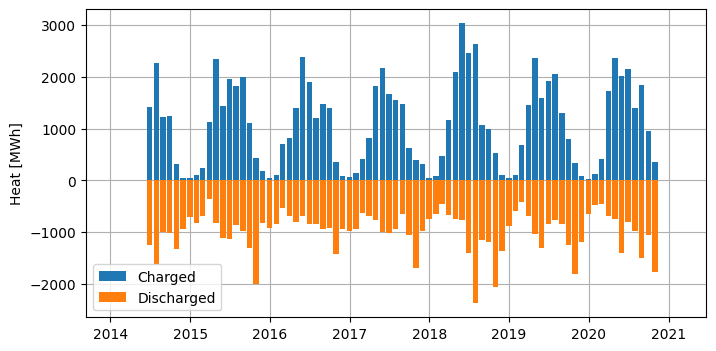

In [13]:
df_monthly = df.resample('1M').sum()

width = pd.Timedelta(days=25)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df_monthly.index, df_monthly['Q_ch_bot_calc'], width=width, label='Charged', zorder=2)
ax.bar(df_monthly.index, -df_monthly['Q_dis_bot_calc'], width=width, label='Discharged', zorder=2)
ax.set_ylabel('Heat [MWh]')
ax.legend()
ax.grid()

<br> For comparison, the charged and discharged energy were also calculated using the original flow rates and directions provided in the dataset.

In [14]:
# Convert the flow directions from [0,1] to [-1,1] assuming that
# positive is influx and negative is outflux of water from the PTES.
df['FR_top_c'] = df['FR_top']*-2+1
df['FR_mid_c'] = df['FR_mid']*-2+1
df['FR_bot_c'] = df['FR_bot']*-2+1

# Calculate energy transferred in each diffuser
df['Q_top'] = df['F_top']*(df['T_top']-T_ref)*fac*df['FR_top_c'] 
df['Q_mid'] = df['F_mid']*(df['T_mid']-T_ref)*fac*df['FR_mid_c']
df['Q_bot'] = df['F_bot']*(df['T_bot']-T_ref)*fac*df['FR_bot_c']

# Calculate net charged and discharged energy
df['Q_ch_dir'] = df[['Q_top','Q_mid','Q_bot']].sum(axis='columns').clip(lower=0)
df['Q_dis_dir'] = -df[['Q_top','Q_mid','Q_bot']].sum(axis='columns').clip(upper=0)

<br> Monthly bar plot for the charged and discharged energy based on the original provided flow rates and directions.

C:\Users\peter\AppData\Local\Temp\ipykernel_17304\3412569888.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('1M').sum()


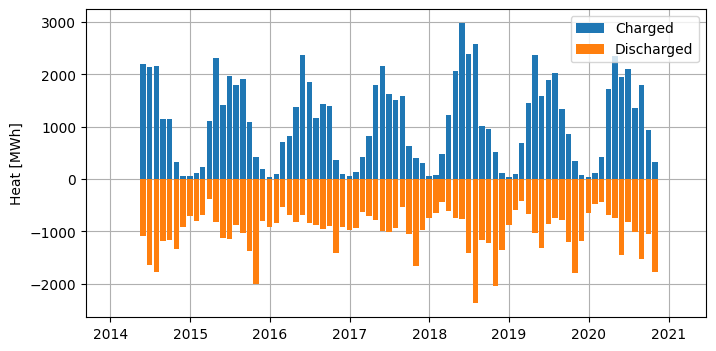

In [15]:
df_monthly = df.resample('1M').sum()

width = pd.Timedelta(days=25)

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(df_monthly.index, df_monthly['Q_ch_dir'], width=width, label='Charged', zorder=2)
ax.bar(df_monthly.index, -df_monthly['Q_dis_dir'], width=width, label='Discharged', zorder=2)
ax.set_ylabel('Heat [MWh]')
ax.legend()
ax.grid()

<br>

## Comparison of charged and discharged energy

So far two strategies have been demonstrated for calculating the charged and discharged energy to the storage, either using the original provided flow rates or using the newly calculated flow directions as shown earlier.

Below is shown a comparision of the charged and discharged energy using the two different flow directions. These values are compared to the charged/discharged energy calculated using the overall energy balance of the storage (which has a low uncertainty).

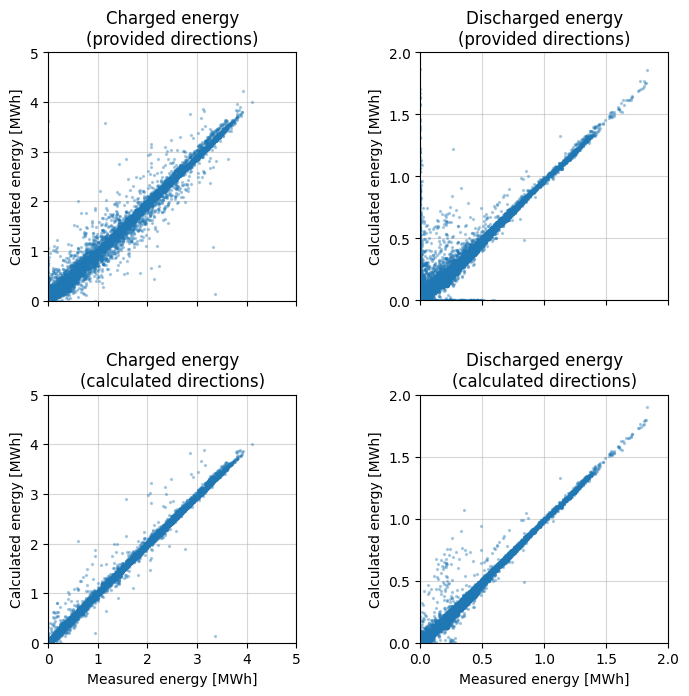

In [16]:
al = 0.3  # opacity of the scatter points

freq = '1h'
df_hourly = df.resample('1h').mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,10), sharex='col',
                         sharey=False, subplot_kw=dict(aspect='equal'))
axes = axes.flatten()

# Comparison of energy rates based on provided flow directions
axes[0].scatter(df_hourly['Q_ch_net'], df_hourly['Q_ch_dir'], s=2, alpha=al, zorder=2)
axes[1].scatter(df_hourly['Q_dis_net'], df_hourly['Q_dis_dir'], s=2, alpha=al, zorder=2)
axes[0].set_title('Charged energy\n(provided directions)')
axes[1].set_title('Discharged energy\n(provided directions)')

# Comparison of energy rates bassed on the calculated flow rates
axes[2].scatter(df_hourly['Q_ch_net'], df_hourly['Q_ch_bot_calc'], s=2, alpha=al, zorder=2)
axes[3].scatter(df_hourly['Q_dis_net'], df_hourly['Q_dis_bot_calc'], s=2, alpha=al, zorder=2)
axes[2].set_title('Charged energy\n(calculated directions)')
axes[3].set_title('Discharged energy\n(calculated directions)')

# Set axis limits
for i, ax in enumerate(axes):
    if i % 2 == 0:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)
    else:
        ax.set_xlim(0, 2)
        ax.set_ylim(0, 2)
    ax.grid(alpha=0.5)


# Set axis y and x labels
axes[0].set_ylabel('Calculated energy [MWh]')
axes[1].set_ylabel('Calculated energy [MWh]')
axes[2].set_ylabel('Calculated energy [MWh]')
axes[3].set_ylabel('Calculated energy [MWh]')
axes[2].set_xlabel('Measured energy [MWh]')
axes[3].set_xlabel('Measured energy [MWh]')

# Set axis y and x ticks
axes[1].set_yticks(np.arange(0, 2.5, 0.5))
axes[3].set_yticks(np.arange(0, 2.5, 0.5))
axes[1].set_xticks(np.arange(0, 2.5, 0.5))
axes[3].set_xticks(np.arange(0, 2.5, 0.5))
axes[0].set_yticks(np.arange(0, 6, 1))
axes[2].set_yticks(np.arange(0, 6, 1))
axes[0].set_xticks(np.arange(0, 6, 1))
axes[2].set_xticks(np.arange(0, 6, 1))

fig.subplots_adjust(wspace=0.5, hspace=-0.2)

<br> Save data as a csv file.

In [19]:
df.to_csv('../data/processed/Dronninglund_treated_data_and_flow_rates.csv')

In [18]:
df

,SO.DA.ET.422.5,SO.DA.HT.422.1.F,SO.DA.HT.422.1.T,SO.DA.HT.422.2.F,SO.DA.HT.422.2.T,SO.DA.LT.421,T_00.5,T_01.5,T_02.5,T_03.5,...,Q_ch_bot_calc,Q_dis_bot_calc,FR_top_c,FR_mid_c,FR_bot_c,Q_top,Q_mid,Q_bot,Q_ch_dir,Q_dis_dir
2014-01-01 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2014-01-01 01:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2014-01-01 01:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2014-01-01 01:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2014-01-01 01:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01 00:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2021-01-01 00:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2021-01-01 00:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
2021-01-01 00:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0
